Свёрточные нейронные сети и transfer learning для изображений.

Датасет: Hotdog / Not hotdog.

Метрика: Accuracy

Сделать модель бинарной классификации изображений с использованием примера имплементации.

- Обучить модель с нуля
- Дообучить предобученную модель
- Сравнить качество

In [1]:
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade seaborn
!pip install --upgrade tensorflow
!pip install --upgrade keras

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.24.1)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)
Requirement already up-to-date: tensorflow in c:\anaconda\lib\site-packages (1.12.0)
Requirement already up-to-date: keras in c:\anaconda\lib\site-packages (2.2.4)


In [2]:
#imports
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)
import json
from tqdm import tqdm
seed = 321



#keras
from sklearn.metrics import f1_score, classification_report
from keras import applications
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, image
from keras.models import Sequential, load_model,model_from_json
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras import backend as K
from keras.regularizers import l1_l2
from keras.layers import LeakyReLU, BatchNormalization
from keras.optimizers import SGD


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


Set pictures parameters

In [3]:
img_width = 224
img_height = 224
batch_size = 16
path = "data/task_3/"
img_classes = ['hot_dog','not_hot_dog']

In [4]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True) #Randomly flip inputs horizontally


test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
#Takes the path to a directory & generates batches of augmented data.
train_generator = train_datagen.flow_from_directory(
    path + "train",  # this is the target directory
    target_size=(img_width, img_height),  # all images will be resized to NxN
    batch_size=batch_size,
    class_mode='binary',# since we use binary_crossentropy loss, we need binary labels
    classes = img_classes,
    seed=seed)  

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        path + "test",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
        classes = img_classes,
        seed=seed)

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


View train/test image before/after preprocess.

In [6]:
def image_preview_transformed(img_array): #with print
    x = img_array.reshape(img_array.shape[2],img_array.shape[1],img_array.shape[3])
    x = image.array_to_img(x)
    plt.imshow(x)
    plt.show()

In [7]:
 def preview_image(image,datagen):
    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    i = 0
    for batch in datagen.flow(image, batch_size=1,
                                    save_to_dir=None, 
                                    save_prefix='hot_dog', save_format='jpeg'):
        image_preview_transformed(batch)
        i += 1  
        if i > 5:
            break  # otherwise the generator would loop indefinitely

(1, 224, 224, 3)


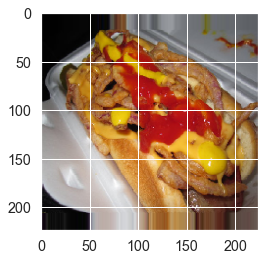

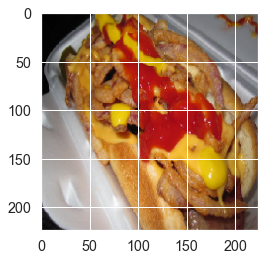

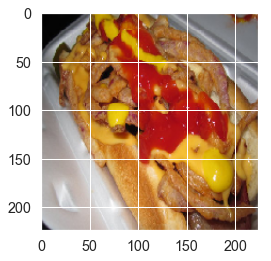

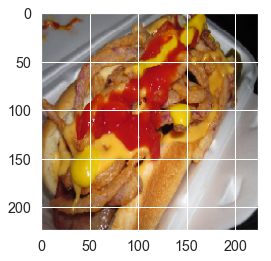

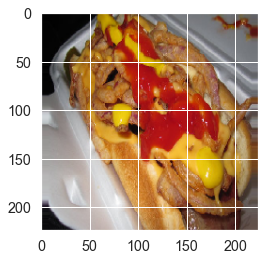

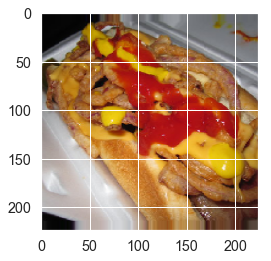

In [8]:
img = load_img(path + "train/hot_dog/2417.jpg",target_size=(img_width, img_height))  # this is a PIL image

#plt.imshow(img)

x = img_to_array(img)  # this is a Numpy array with shape (3, 200, 200)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 200, 200, 3)
print (x.shape)

preview_image(x, train_datagen)

(1, 224, 224, 3)


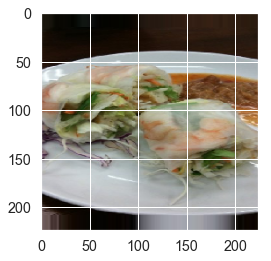

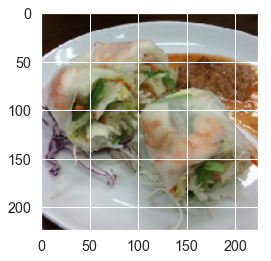

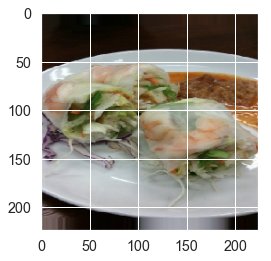

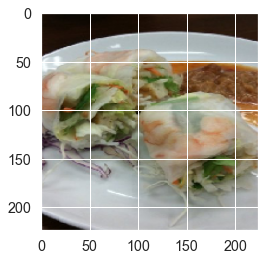

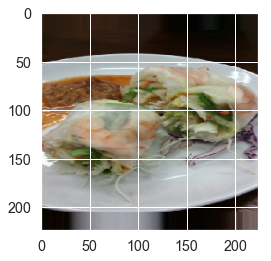

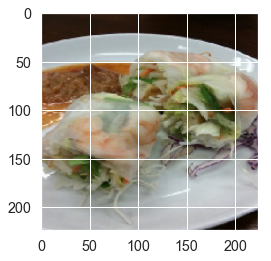

In [9]:
img = load_img(path + "train/not_hot_dog/197.jpg",target_size=(img_width, img_height))  # this is a PIL image

x = img_to_array(img)  # this is a Numpy array with shape (3, 200, 200)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 200, 200, 3)
print (x.shape)


preview_image(x, train_datagen)

Model creation function.

In [10]:
def create_seq_model():
    model = Sequential()
    #filters = output dimension, kernel_size = specify the size of kernel,
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape=(img_width, img_height, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
    # pool size, reduce size of the output matrix
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    #units = output dimension shape
    model.add(Dense(units = 32, activation='relu'))
    #randomly select amount of %rate of the neurons and set their weights to zero for the forward and backward passes 
    #i.e. for one iteration.
    model.add(Dropout(rate = 0.5))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [11]:
checkpoint_filepath = 'models/conv2d/'

checkpoint = ModelCheckpoint(checkpoint_filepath + 'baseline_model.hdf5', monitor='val_loss', 
                             verbose=0, save_best_only=True, mode='min')


earlyStopping = EarlyStopping(monitor='val_loss', patience=15, 
                              verbose=1, min_delta=0.02,
                              mode='min',restore_best_weights=True)

callbacks = [checkpoint,earlyStopping]

In [12]:
baseline_model = create_seq_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)             0         
__________

In [13]:
history = baseline_model.fit_generator(
    train_generator,
    steps_per_epoch=1000 // batch_size,
    epochs=50,
    verbose = 2,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=800 // batch_size)

Epoch 1/50
 - 105s - loss: 0.6989 - acc: 0.4931 - val_loss: 0.6888 - val_acc: 0.6345
Epoch 2/50
 - 95s - loss: 0.6925 - acc: 0.5221 - val_loss: 0.6809 - val_acc: 0.5928
Epoch 3/50
 - 98s - loss: 0.6917 - acc: 0.5100 - val_loss: 0.6927 - val_acc: 0.5571
Epoch 4/50
 - 91s - loss: 0.6931 - acc: 0.5030 - val_loss: 0.6932 - val_acc: 0.4871
Epoch 5/50
 - 99s - loss: 0.6938 - acc: 0.4861 - val_loss: 0.6932 - val_acc: 0.4721
Epoch 6/50
 - 101s - loss: 0.6932 - acc: 0.5059 - val_loss: 0.6928 - val_acc: 0.5696
Epoch 7/50
 - 99s - loss: 0.6931 - acc: 0.5090 - val_loss: 0.6939 - val_acc: 0.3909
Epoch 8/50
 - 95s - loss: 0.6931 - acc: 0.5129 - val_loss: 0.6914 - val_acc: 0.6443
Epoch 9/50
 - 86s - loss: 0.6932 - acc: 0.4971 - val_loss: 0.6945 - val_acc: 0.3634
Epoch 10/50
 - 87s - loss: 0.6933 - acc: 0.4970 - val_loss: 0.6926 - val_acc: 0.5939
Epoch 11/50
 - 86s - loss: 0.6932 - acc: 0.4929 - val_loss: 0.6935 - val_acc: 0.4459
Restoring model weights from the end of the best epoch
Epoch 00011: earl

dict


In [59]:
def plot_loss_acc(history):
    if type(history) != dict:
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(10, 5)
        # summarize history for loss
        ax[0].plot(history.history['loss'])
        ax[0].plot(history.history['val_loss'])
        ax[0].set_title('model loss')
        ax[0].set_ylabel('loss')
        ax[0].set_xlabel('epoch')
        ax[0].legend(['train', 'test'], loc='upper left')

        # summarize history for accuracy
        ax[1].plot(history.history['acc'])
        ax[1].plot(history.history['val_acc'])
        ax[1].set_title('model accuracy')
        ax[1].set_ylabel('accuracy')
        ax[1].set_xlabel('epoch')
        ax[1].legend(['train', 'test'], loc='upper left')
        fig.show()
    else:
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(10, 5)
        # summarize history for loss
        ax[0].plot(history['loss'])
        ax[0].plot(history['val_loss'])
        ax[0].set_title('model loss')
        ax[0].set_ylabel('loss')
        ax[0].set_xlabel('epoch')
        ax[0].legend(['train', 'test'], loc='upper left')

        # summarize history for accuracy
        ax[1].plot(history['acc'])
        ax[1].plot(history['val_acc'])
        ax[1].set_title('model accuracy')
        ax[1].set_ylabel('accuracy')
        ax[1].set_xlabel('epoch')
        ax[1].legend(['train', 'test'], loc='upper left')
        fig.show()
        

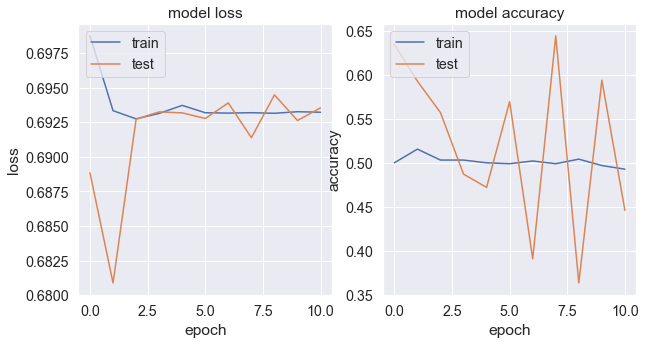

In [60]:
plot_loss_acc(history)

In [20]:
#original model
result = baseline_model.evaluate_generator(validation_generator, steps = 800 // batch_size)
print('Loss for val: {}\nAccuracy for val: {}'.format(result[0], result[1]))

Loss for val: 0.6930382693479509
Accuracy for val: 0.4720812182741117


In [35]:
baseline_model.layers[0].get_weights()

[array([[[[  1.22486934e-01,  -1.17101809e-02,   2.31428128e-02,
             5.98721914e-02,  -7.50537142e-02,  -7.81334564e-02,
            -1.41845167e-01,   9.42525715e-02,   9.11621898e-02,
             2.63088252e-02,  -4.28706445e-02,   7.00155050e-02,
            -3.30021046e-02,   3.42464074e-03,   5.75970719e-03,
             7.50495568e-02,   1.37375772e-01,   1.07769080e-01,
             1.22772917e-01,  -6.80845678e-02,   9.30578411e-02,
            -1.40557364e-01,   1.13826118e-01,   1.21609764e-02,
             6.27867877e-02,  -1.17779523e-01,  -7.70236775e-02,
             1.34742940e-02,  -1.30335882e-01,   3.18845585e-02,
             5.79733727e-03,   6.64742514e-02],
          [ -1.00986771e-01,   2.17573456e-02,  -4.55441289e-02,
            -4.32238877e-02,   1.68473106e-02,  -1.20263986e-01,
             1.00836709e-01,   1.77138671e-02,   1.57572515e-02,
            -9.18766111e-02,   1.31119356e-01,  -1.94442496e-02,
             1.20969146e-01,  -1.12731718e

In [16]:
# serialize model to JSON
model_json = baseline_model.to_json()

with open(checkpoint_filepath + "model" + ".json", "w") as json_file:
    json_file.write(model_json)

with open(checkpoint_filepath + "history"+ ".json", 'w') as f:
    json.dump(history.history, f)
    
# serialize weights to HDF5
baseline_model.save_weights(checkpoint_filepath + "model_weights" +  ".h5")
print("Saved model to disk")

Saved model to disk


In [21]:
# my load
# load json and create model
json_file = open(checkpoint_filepath + "model" + ".json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(checkpoint_filepath + "model_weights" +  ".h5")
print("Loaded model from disk")

#load history
json_file = open(checkpoint_filepath + "history"+ ".json", 'r')
loaded_history_json = json.load(json_file)
json_file.close()

loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
result = loaded_model.evaluate_generator(validation_generator, steps = 800 // batch_size)
print('Loss for val: {}\nAccuracy for val: {}'.format(result[0], result[1]))

Loaded model from disk
Loss for val: 0.6915172277973388
Accuracy for val: 0.5329949238578681


In [34]:
loaded_model.layers[0].get_weights()

[array([[[[  1.22486934e-01,  -1.17101809e-02,   2.31428128e-02,
             5.98721914e-02,  -7.50537142e-02,  -7.81334564e-02,
            -1.41845167e-01,   9.42525715e-02,   9.11621898e-02,
             2.63088252e-02,  -4.28706445e-02,   7.00155050e-02,
            -3.30021046e-02,   3.42464074e-03,   5.75970719e-03,
             7.50495568e-02,   1.37375772e-01,   1.07769080e-01,
             1.22772917e-01,  -6.80845678e-02,   9.30578411e-02,
            -1.40557364e-01,   1.13826118e-01,   1.21609764e-02,
             6.27867877e-02,  -1.17779523e-01,  -7.70236775e-02,
             1.34742940e-02,  -1.30335882e-01,   3.18845585e-02,
             5.79733727e-03,   6.64742514e-02],
          [ -1.00986771e-01,   2.17573456e-02,  -4.55441289e-02,
            -4.32238877e-02,   1.68473106e-02,  -1.20263986e-01,
             1.00836709e-01,   1.77138671e-02,   1.57572515e-02,
            -9.18766111e-02,   1.31119356e-01,  -1.94442496e-02,
             1.20969146e-01,  -1.12731718e

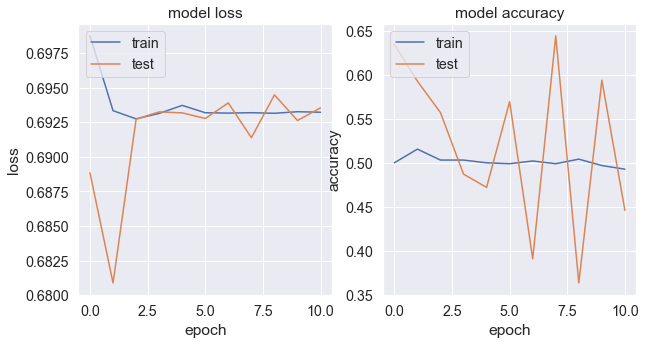

In [61]:
plot_loss_acc(loaded_history_json)

In [22]:
#checkpoint
model = load_model(checkpoint_filepath + 'baseline_model.hdf5')

result = model.evaluate_generator(validation_generator, steps = 800 // batch_size)
print('Loss for val: {}\nAccuracy for val: {}'.format(result[0], result[1]))

Loss for val: 0.7101476967032185
Accuracy for val: 0.4086294416243655


In [33]:
model.layers[0].get_weights()

[array([[[[  1.16302751e-01,   1.24794543e-02,   2.38923915e-02,
             5.73972277e-02,  -7.93423653e-02,  -7.72725493e-02,
            -1.40953615e-01,   9.18467566e-02,   8.84371996e-02,
             2.63521690e-02,  -4.40195054e-02,   6.66440278e-02,
            -3.16337161e-02,   1.17161509e-03,   4.60823113e-03,
             7.56763890e-02,   1.39888361e-01,   1.07504524e-01,
             1.17498651e-01,  -7.15924501e-02,   8.68186802e-02,
            -1.50834590e-01,   1.14511721e-01,   1.33135831e-02,
             6.16758130e-02,  -1.06336437e-01,  -7.69787878e-02,
             9.98034328e-03,  -1.28006965e-01,   3.04323342e-02,
             7.95606524e-03,   6.18469194e-02],
          [ -1.07184336e-01,   4.76866141e-02,  -4.61009145e-02,
            -4.61520255e-02,   1.18507938e-02,  -1.20908082e-01,
             1.00715466e-01,   1.41446982e-02,   1.28760114e-02,
            -9.14378613e-02,   1.29263982e-01,  -2.33693533e-02,
             1.25838280e-01,  -1.14456959e

#### VGG16.